## Is it a shark or a whale?

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images of sharks and whales

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(term,max_results=max_images)
        return L(ddgs_images_gen).itemgot('image')

In [4]:
searches = 'shark','whale'
path = Path('shark_or_not')
from time import sleep
from fastai.vision.all import *


for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'small {o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'big {o} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Searching for 'shark photo'
Searching for 'small shark photo'
Searching for 'big shark photo'
Searching for 'whale photo'
Searching for 'small whale photo'
Searching for 'big whale photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

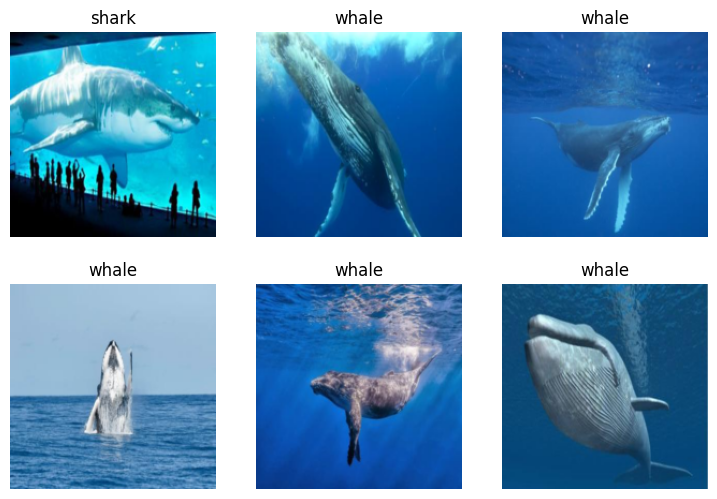

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.194253,1.394557,0.468750,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.524052,0.616335,0.250000,00:00
1,0.319017,0.346817,0.156250,00:00
2,0.212957,0.271836,0.125000,00:00


## Clean data

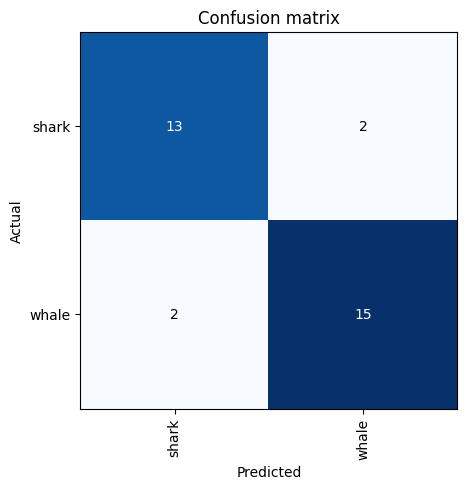

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
     

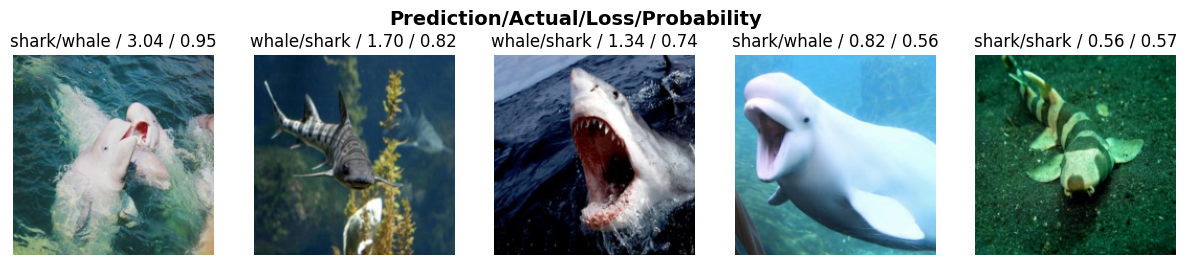

In [9]:
interp.plot_top_losses(5, nrows=1)

In [10]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [11]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Step 3: Export our model

In [12]:
learn.export('model.pkl')